In [2]:
import gym
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

import skimage

from torch import nn
import torch.nn.functional as F

from tqdm.notebook import tqdm_notebook as tqdm

import pickle

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GAMMA = 0.999
K = 4 # each state is a block of 4 states, the agent selects action every k states

### Create Environment Handler Class

In [4]:
class EnvironmentHandler:
    def __init__(self, env_name = "Pong-v0"):
        self.env = gym.make(env_name)
        
    def _preprocess_image(self,image):
        gray = skimage.color.rgb2gray(image)
        downscale = skimage.transform.resize(gray, (110, 84), anti_aliasing=False)
        crop = downscale[18:102]
        normalize = crop/255.0
        return normalize
    
    def reset(self):
        self.env.reset()
        
    def get_next_k_states(self, k, action):
        """returns a tensor image with k channels shape = (k,h,w)"""
        images = []
        rewards = []
        done = []
        for i in range(k):
            image,reward,d,_ = self.env.step(action if i == 0 else 0)
            images.append(torch.tensor(self._preprocess_image(image), dtype = torch.float32).unsqueeze(0))
            rewards.append(reward)
            done.append(d)
        self.rewards = rewards
        self.dones = done
        return torch.cat(images).unsqueeze(0).to(DEVICE)
    
    def sample_action_space(self):
        return self.env.action_space.sample()
        
    def get_reward(self):
        return sum(self.rewards)
    
    def close(self):
        self.env.close()
    
    @property
    def done(self):
        for d in self.dones:
            if d:
                return True
        return False
    
    @property
    def action_space(self):
        return self.env.action_space
        

### Create Experience Class

In [5]:
class Experience:
    def __init__(self, state, action, reward, next_state):
        self.state = state
        self.action = action
        self.reward = reward
        self.next_state = state

### Create Cache

This is smart! Overwriting previous array values is more efficient than shifting everything backwards.

In [6]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.cache = []
        self.cache_pointer = 0
        
    def __len__(self):
        return len(self.cache)
    
    def push(self, experience):
        if len(self.cache) < self.capacity:
            self.cache.append(experience)
        else:
            self.cache[self.cache_pointer] = experience
        self.cache_pointer = (self.cache_pointer + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.cache, batch_size)
    '''
    def get_last_n_frames(self, n = 4):
        next_index = self.cache_pointer + len(self.cache)
        last_n_frames = [torch.tensor(exp.state, dtype = torch.float32).unsqueeze(0) for exp in (self.cache * 2)[next_index - n: next_index]]
        return torch.cat(last_n_frames).unsqueeze(0).to(DEVICE)'''

### Create DQN

In [7]:
class DQN(torch.nn.Module):
    def __init__(self, action_space_size):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 16, 8, stride = 4)
        self.conv2 = nn.Conv2d(16, 32, 4, stride = 2)
        self.fc1 = nn.Linear(2592, 256)
        self.fc2 = nn.Linear(256, action_space_size)
        
    def forward(self,x):
        """Input should be 4x84x84"""
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.flatten(start_dim = 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Create Epsilon Scheduling

In [8]:
def epsilon(start = 1, stop = 0.1, num = 1_000_000):
    epsilons = np.linspace(start, stop, num)
    for i in epsilons:
        yield i
    while True:
        yield stop

### Training

In [9]:
env_handler = EnvironmentHandler()
env_handler.reset()

In [10]:
memory = ReplayMemory(1500)
dqn = DQN(3)
dqn.to(DEVICE)

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=2592, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)

### Load saved model

In [25]:
state_dict = torch.load("dqn_at_ep1000")

In [26]:
dqn.load_state_dict(state_dict)

<All keys matched successfully>

In [27]:
optimizer = torch.optim.RMSprop(dqn.parameters(), lr=0.0025)

In [29]:
episodes = 5000
batch_size = 32
epsilon_generator = iter(epsilon(0.8,0.05,500000))

#initialize current_state
current_state = env_handler.get_next_k_states(K, 0)

for episode in tqdm(range(1000,episodes)):
    done = False
    env_handler.reset()
    while not done:
        if random.uniform(0,1) < next(epsilon_generator):
            #action = env_handler.action_space.sample()
            action = random.sample([1,2,3],1)
        else:
            with torch.no_grad():
                # action = dqn(current_state).argmax().item()
                action = dqn(current_state).argmax().item() + 1 # choose betwen 1,2,3
        next_state = env_handler.get_next_k_states(K, action)
        reward = env_handler.get_reward()    
        done = env_handler.done
        memory.push(Experience(current_state, action, reward, next_state))
        
        if len(memory) < batch_size:
            break
        
        random_minibatch = memory.sample(batch_size)
        
        y = torch.tensor([exp.reward for exp in random_minibatch], device = DEVICE)
        if not done:
            batch_next_state = torch.cat([exp.next_state for exp in random_minibatch])
            y = y + GAMMA * dqn(batch_next_state).max(dim = 1)[0]
        
        batch_current_state = torch.cat([exp.state for exp in random_minibatch])
        
        l = ((y - dqn(batch_current_state).max(dim = 1)[0])**2).mean()
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        #update current state for next cycle
        current_state = next_state
        
        if episode%10 == 0:
            env_handler.env.render()
    if episode%100 == 0:
        torch.save(dqn.state_dict(), f"./dqn_at_ep{episode}")
env_handler.close()   

KeyboardInterrupt: 

In [30]:
env_handler.close()

In [37]:
next(epsilon_generator)

0.9981918981918982

In [34]:
len(memory)

1000

In [417]:
foo.max(dim = 1)[0] + y

tensor([ 0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323, -0.9677,  0.0323,
         0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323,
         0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323,
         0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323,  0.0323],
       device='cuda:0', grad_fn=<AddBackward0>)

In [319]:
memory.sample(3)

In [299]:
torch.tensor([1,2], device = DEVICE) * 3

tensor([3, 6], device='cuda:0')

In [305]:
x = torch.tensor(2.0, requires_grad = True)

In [306]:
y = x**2

In [307]:
z = x**3

In [308]:
y.backward()

In [309]:
x.grad

tensor(4.)

In [310]:
z.backward()

In [311]:
x.grad

tensor(16.)

In [271]:
next(foo)

0.9999972999973

In [282]:
current_state = env.render(mode = "rgb_array")
action = env.action_space.sample()
next_state, reward, _, _ = env.step(action)
for _ in range(4):
    memory.push(Experience(current_state, action, reward, next_state))

In [284]:
with torch.no_grad():
    foo =dqn(memory.get_last_n_frames())


In [292]:
foo.argmax().item()

1

### Scratch Zone

In [24]:
foo = env.render(mode = "rgb_array")

In [111]:
foo.shape

(210, 160, 3)

In [98]:
env.step(env.action_space.sample())
foo = env.render(mode = "rgb_array")
bar = rgb2gray(foo)

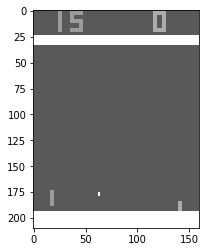

In [108]:
plt.imshow(image, cmap="gray")
plt.show()

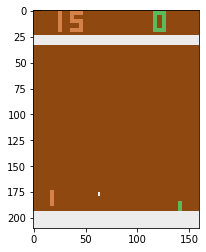

In [100]:
plt.imshow(foo)

In [275]:
memory = ReplayMemory(10)

In [276]:
env.reset()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       ...,

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]]

In [277]:
done = False
while not done:
    current_state = env.render(mode = "rgb_array")
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.push(Experience(current_state, action, reward, next_state))

In [278]:
env.close()

In [279]:
memory.get_last_n_frames().shape

torch.Size([1, 4, 84, 84])

In [280]:
DEVICE

device(type='cuda')

In [323]:
env

<TimeLimit<AtariEnv<Pong-v0>>>

In [324]:
def foo (env):
    env = 2

In [327]:
foo(env)

In [328]:
env

<TimeLimit<AtariEnv<Pong-v0>>>

In [254]:
dqn = DQN(6)
dqn.to(DEVICE)

DQN(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=2592, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

In [255]:
dqn(memory.get_last_n_frames())

tensor([[ 0.0495, -0.0457, -0.0279,  0.0414,  0.0378, -0.0152]],
       device='cuda:0', grad_fn=<AddmmBackward>)